# Fitting the basic model on Linux dataset

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf
import math
import os
import matplotlib.pyplot as plt
import numpy as np

from interank import linuxutils
from interank.models import WhitehillModel
from interank.linuxdata import LinuxData
from datetime import datetime as dt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score

summaries_dir = '../trained-models/log-dir/'

## Load dataset

In [3]:
%%time
dataset = LinuxData("/data/datasets/linux")

train = dataset.get_train_data()
test = dataset.get_test_data()

print("Training set: {} edits".format(len(train[0])))
print("Test set: {} edits".format(len(test[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_subsystems))
print("––––––––––")

Training set: 495536 edits
Test set: 123883 edits
Number of users: 9672
Number of articles: 394
––––––––––
CPU times: user 1.06 s, sys: 60 ms, total: 1.12 s
Wall time: 1.08 s


## Tensorflow configuration

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# Reset graph to run the notebook twice in a row without error 
tf.reset_default_graph()

# Global bias
global_bias = True

# Basic model
model = WhitehillModel(n_users=dataset.n_users,
                   n_articles=dataset.n_subsystems,
                   global_bias=global_bias)

# Setup the optimisation procedure
minibatch_size = 2000
minibatch_size_tf = tf.Variable(minibatch_size, trainable=False)
num_batches = math.ceil(len(train[0]) / minibatch_size)
epochs = 50

# Define the cost
reg_coeff = 32
cost = -model.log_likelihood + (reg_coeff / num_batches) * (model.l2_skill + model.l2_difficulty)

# Setup optimiser
learning_rate = 0.1

# Decaying learning rate
# decay_rate = 0.9
# global_step = 0
# Decaying learning rate
# batch_idx = tf.Variable(0, trainable=False)
# learning_rate_tf = tf.train.exponential_decay(
#     learning_rate=learning_rate,
#     global_step=(batch_idx * minibatch_size),
#     decay_steps=len(train[0]),
#     decay_rate=decay_rate,
#     staircase=True
# )
# train_step = tf.train.GradientDescentOptimizer(learning_rate_tf).minimize(cost, global_step=batch_idx)

# Adagrad
learning_rate_tf = tf.Variable(learning_rate, dtype=tf.float32)
train_step = tf.train.AdagradOptimizer(learning_rate_tf).minimize(cost)

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
tf.summary.scalar("learning_rate", learning_rate_tf)
merged = tf.summary.merge_all()
    
log = 'tuned/optimization_{}_epochs_{}_minibatchsize_{}__learningrate_{}_date_{}'.format(
    'Adagrad',
    epochs,
    minibatch_size,
    learning_rate,
    dt.now().strftime('%Y-%m-%d-%H-%M-%S')
)
train_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/train')
test_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/test')

## Train the model

In [6]:
%%time
feed_test = {
    model.user_id: test[0],
    model.article_id: test[1],
    model.quality: test[2],
}

# Keep track of likelihood
test_likelihood = [-np.inf]

print('Total number of batches: {}'.format(num_batches))

def evaluate(session, step):
    if global_bias:
        avg_log_loss, probs, bias = session.run(
                [model.avg_log_loss, model.probability, model.global_bias], feed_dict=feed_test)
    else:
        avg_log_loss, probs = session.run(
                [model.avg_log_loss, model.probability], feed_dict=feed_test)
        bias = None
        
    
    labels = feed_test[model.quality].astype(int)
    auc = average_precision_score(labels, probs)
    
    summary = session.run(merged, feed_dict={**feed_test, auc_ph: auc})
    
    test_writer.add_summary(summary, global_step=step)
    test_writer.flush()
    
    return avg_log_loss, auc, bias
    

# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

with session.as_default():
    step = 0

    avg_log_loss, auc, bias = evaluate(session, step)
    print('Epoch 0 - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
          .format(avg_log_loss, auc, bias))

    for i in range(epochs):
        # Train the model on minibatch
        for j, minibatch in enumerate(LinuxData.minibatches(train, minibatch_size)):
            step += 1
            feed_dict = {
                model.user_id: minibatch[0],
                model.article_id: minibatch[1],
                model.quality: minibatch[2],
            }
            _ = session.run([train_step], feed_dict=feed_dict)

        avg_log_loss, auc, bias = evaluate(session, step)
        print('Epoch {} - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
              .format(i + 1, avg_log_loss, auc, bias))

Total number of batches: 248
Epoch 0 - avg. log-loss = 1.875856, AUC = 0.333, bias = 0.0
Epoch 1 - avg. log-loss = 0.597031, AUC = 0.504, bias = -1.1729146242141724
Epoch 2 - avg. log-loss = 0.595758, AUC = 0.507, bias = -1.1686899662017822
Epoch 3 - avg. log-loss = 0.595578, AUC = 0.507, bias = -1.1309354305267334
Epoch 4 - avg. log-loss = 0.595283, AUC = 0.506, bias = -1.097846508026123
Epoch 5 - avg. log-loss = 0.595106, AUC = 0.507, bias = -1.0648432970046997
Epoch 6 - avg. log-loss = 0.595116, AUC = 0.507, bias = -1.0428602695465088
Epoch 7 - avg. log-loss = 0.595211, AUC = 0.506, bias = -1.022704005241394
Epoch 8 - avg. log-loss = 0.595600, AUC = 0.505, bias = -1.0022634267807007
Epoch 9 - avg. log-loss = 0.595931, AUC = 0.504, bias = -0.9863356947898865
Epoch 10 - avg. log-loss = 0.596140, AUC = 0.504, bias = -0.9734044075012207
Epoch 11 - avg. log-loss = 0.595872, AUC = 0.504, bias = -0.9631100296974182
Epoch 12 - avg. log-loss = 0.595932, AUC = 0.505, bias = -0.949401140213012

## Evaluate

In [7]:
with session.as_default():
    probs = session.run(
            [model.probability], feed_dict=feed_test)

### Precision-recall curve

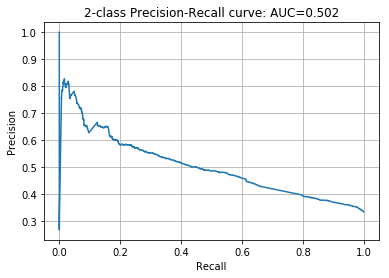

In [8]:
target = np.array([np.float32(t) for t in test[2]]).squeeze()
predictions = np.array(probs).squeeze()

average_precision = average_precision_score(target, predictions)
precision, recall, _ = precision_recall_curve(target, predictions)

plt.plot(recall, precision)

plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AUC={0:0.3f}'.format(
          average_precision))
plt.show()

## Qualitative results

In [9]:
with session.as_default():
    skills = model.skill.eval()
    difficulties = model.difficulty.eval()
subsystems = dataset.get_subsystems()
users = dataset.get_users()

In [10]:
linuxutils.print_subsystems_summary(1 / np.exp(difficulties), subsystems, n=10)

### 10 most difficult subsystems:
 1 +1.457 usr (796 patches, 70 users)
    rate: 1.8844%, main contributor: fujita.tomonori@lab.ntt.co.jp
 2 +1.194 drivers/target (1093 patches, 48 users)
    rate: 27.4474%, main contributor: nab@linux-iscsi.org
 3 +1.182 arch/ppc64 (288 patches, 53 users)
    rate: 27.7778%, main contributor: paulus@samba.org
 4 +1.180 drivers/ps3 (61 patches, 9 users)
    rate: 44.2623%, main contributor: torvalds@linux-foundation.org
 5 +1.129 include/acpi (311 patches, 50 users)
    rate: 30.8682%, main contributor: lenb@kernel.org
 6 +1.031 fs/9p (345 patches, 49 users)
    rate: 43.1884%, main contributor: aneesh.kumar@gmail.com
 7 +1.030 drivers/sfi (11 patches, 3 users)
    rate: 36.3636%, main contributor: lenb@kernel.org
 8 +1.028 include/asm-xtensa (55 patches, 17 users)
    rate: 32.7273%, main contributor: torvalds@linux-foundation.org
 9 +1.025 fs/bfs (78 patches, 18 users)
    rate: 26.9231%, main contributor: torvalds@linux-foundation.org
10 +1.025 inc

In [11]:
linuxutils.print_users_summary(skills, users, n=10)

### 10 most skilled users:
 1 +0.882 knan-lkml@anduin.net from anduin (78 patches, 3 subsystems)
    rate: 96.1538%, main sub: drivers/ata
 2 +0.867 per.liden@ericsson.com from ericsson (51 patches, 2 subsystems)
    rate: 98.0392%, main sub: net/tipc
 3 +0.824 james.smart@emulex.com from emulex (253 patches, 2 subsystems)
    rate: 93.2806%, main sub: drivers/scsi
 4 +0.815 cmetcalf@tilera.com from tilera (285 patches, 18 subsystems)
    rate: 80.7018%, main sub: arch/tile
 5 +0.794 christof.schmit@de.ibm.com from de.ibm (90 patches, 3 subsystems)
    rate: 95.5556%, main sub: drivers/s390
 6 +0.788 andrew.vasquez@qlogic.com from qlogic (538 patches, 4 subsystems)
    rate: 84.5725%, main sub: drivers/scsi
 7 +0.729 tixy@yxit.co.uk from yxit.co (146 patches, 1 subsystems)
    rate: 87.6712%, main sub: arch/arm
 8 +0.717 madhu.iyengar@qlogic.com from qlogic (111 patches, 2 subsystems)
    rate: 86.4865%, main sub: drivers/scsi
 9 +0.683 gxt@mprc.pku.edu.cn from mprc.pku.edu (61 patches

### Histograms of skills and difficulties

Text(0.5,1,'Histogram of article difficulties')

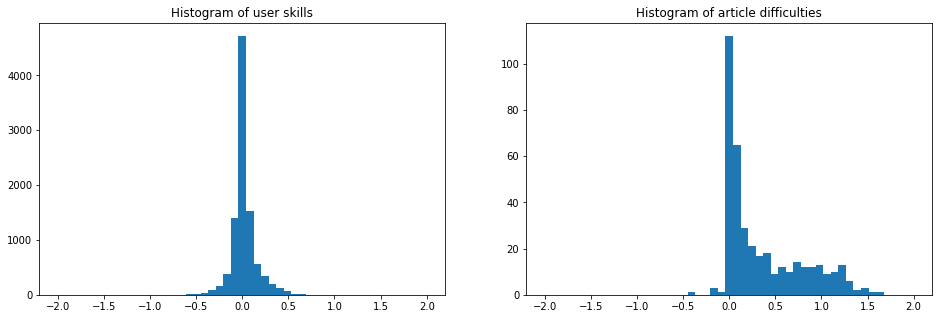

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

ax2.hist(difficulties, bins=np.linspace(-2, 2, num=50))
ax2.set_title("Histogram of article difficulties")

### Histograms of labels

Text(0.5,1,'Histogram of model estimates')

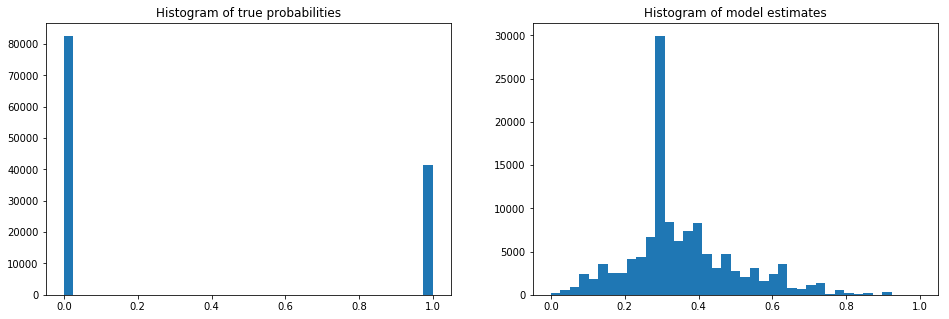

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

In [14]:
saver = tf.train.Saver()
saver.save(session, "../trained-models/linux/whitehill.ckpt")

with open('../data/linux-whitehill-probs.txt', 'w') as f:
    f.writelines(['{:.20f}\n'.format(p) for p in probs[0]])